# Models
From the EDA, I was able to think of my dataset in terms of the officers, the suspects, and the location in which the stops happened. 

In [1]:
# Set Up
import pandas as pd
import numpy as np

# These lines make warnings look nicer
import warnings
warnings.simplefilter('ignore', FutureWarning)

# Graphing
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (10,10)
import seaborn as sns
import plotly as px

# Modeling
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


# Loading Data

In [2]:
sqf = pd.read_csv('../data/cleaned_one_hot.csv').drop('Unnamed: 0', axis = 1)

# Changing columns names to something more comprehendible 
sqf = sqf.rename({'Other1':'Other Hair', 'Other2':'Other Hair 2',
                'Black.1': 'Black Eyes', 'Blue':'Blue Eyes',
                'Brown':'Brown Eyes', 'Green':'Green Eyes',
                'Gray': 'Gray Eyes', 'Hazel': 'Hazel Eyes',
                'Multicolor': 'Multicolor Eyes', 'Other4': 'Other Eyes 4',
                'Other5': 'Other Eyes 5', 'Other6':'Other Eyes 6'}, axis = 1)


# Outline
Outcome Variable: Frisking (1/0)

Feature Sets
1. race
2. appearance (race + physical characteristics)
3. full context (aforementioned + environmental influences)

Models
1. Logistic Regression (Baseline)
2. Logistic Regression with Regularization (avoiding overfitting)
3. SVM

Statistics
1. Accuracy
2. Precision
3. Recall

Goal: a 3x9 table that describes all combinations of the models, featuresets, and statstics (see results.xlxs)

Steps
1. Wrangle the data to create my feature sets
2. Describe the assumptions behind each model
3. Run the function (generalizeable thanks to sklearn)
4. Compile

# Summary Tables

In [3]:
race_summary = pd.DataFrame(columns = ['Accuracy', 'Precision', 'Recall'], 
                       index = ['Logistic', 'Logisitic + Regularization', 'SVM Linear Kernel', 'SVM Gaussian Kernel'])
appearance_summary = pd.DataFrame(columns = ['Accuracy', 'Precision', 'Recall'], 
                       index = ['Logistic', 'Logisitic + Regularization', 'SVM Linear Kernel', 'SVM Gaussian Kernel'])

context_summary = pd.DataFrame(columns = ['Accuracy', 'Precision', 'Recall'], 
                       index = ['Logistic', 'Logisitic + Regularization', 'SVM Linear Kernel', 'SVM Gaussian Kernel'])

# Wrangle
This section will create 3 dataframes
* race contains racial identifying features of the suspect
* appearance contains any physical features of the suspect, including race
* context contains all possible descriptors the environment in which the officer stopped the suspect

In [19]:
y_raw = sqf['frisked_flag']

race = pd.concat([sqf.iloc[:, 23:29]], axis = 1)
appearance = pd.concat([sqf.iloc[:,19:58]], axis = 1)

# One-hot encoding the NY bourough for context 
borough = pd.get_dummies(sqf['stop_location_boro_name'])
context = pd.concat([appearance, borough], axis = 1)

In [21]:
context.shape

(13363, 44)

To speed up the convergence process while running models, I will now normalize these dataframes

In [5]:
def standardize(df):
    """
    A quick, and simple standardization function that relies just on pandas
    Input: dataframe
    Output: dataframe, standardized
    """
    return (df-df.mean())/df.std()

race = standardize(race)
appearance = standardize(appearance)
context = standardize(appearance)

# Naming the dataframe so I can title my ROC graphs ahead
race.name = 'Race'
appearance.name = 'Appearance'
context.name = 'Context'


context.head()

,suspect_reported_age,suspect_height,suspect_weight,female,Indian/Alaskan Native,Asian / Pacific Islander,Black,Black Hispanic,White,White Hispanic,...,Black Eyes,Blue Eyes,Brown Eyes,Green Eyes,Gray Eyes,Hazel Eyes,Multicolor Eyes,Other Eyes 4,Other Eyes 5,Other Eyes 6
0,0.149665,-1.584446,1.959845,-0.316528,-0.022893,-0.151021,0.816695,-0.302741,-0.313514,-0.505984,...,-0.328827,-0.121369,0.445248,-0.082342,-0.044994,-0.08984,-0.012234,-0.019346,-0.012234,-0.193017
1,-0.522424,-1.584446,0.728874,-0.316528,-0.022893,-0.151021,0.816695,-0.302741,-0.313514,-0.505984,...,-0.328827,-0.121369,0.445248,-0.082342,-0.044994,-0.08984,-0.012234,-0.019346,-0.012234,-0.193017
2,2.333951,0.583581,2.575330,-0.316528,-0.022893,-0.151021,-1.224355,-0.302741,3.189407,-0.505984,...,-0.328827,8.238711,-2.245772,-0.082342,-0.044994,-0.08984,-0.012234,-0.019346,-0.012234,-0.193017
3,-0.606435,0.583581,-0.502098,-0.316528,-0.022893,-0.151021,0.816695,-0.302741,-0.313514,-0.505984,...,3.040889,-0.121369,-2.245772,-0.082342,-0.044994,-0.08984,-0.012234,-0.019346,-0.012234,-0.193017
4,-0.942479,0.583581,-0.502098,-0.316528,-0.022893,-0.151021,0.816695,-0.302741,-0.313514,-0.505984,...,3.040889,-0.121369,-2.245772,-0.082342,-0.044994,-0.08984,-0.012234,-0.019346,-0.012234,-0.193017


# Great let's begin modeling 
## Logisitc Regression and LASSO
Especially for the appearance and context datasets, I fear there may be too many features. Hence, in order to get a better general understanding I will regularize with the L1 Norm

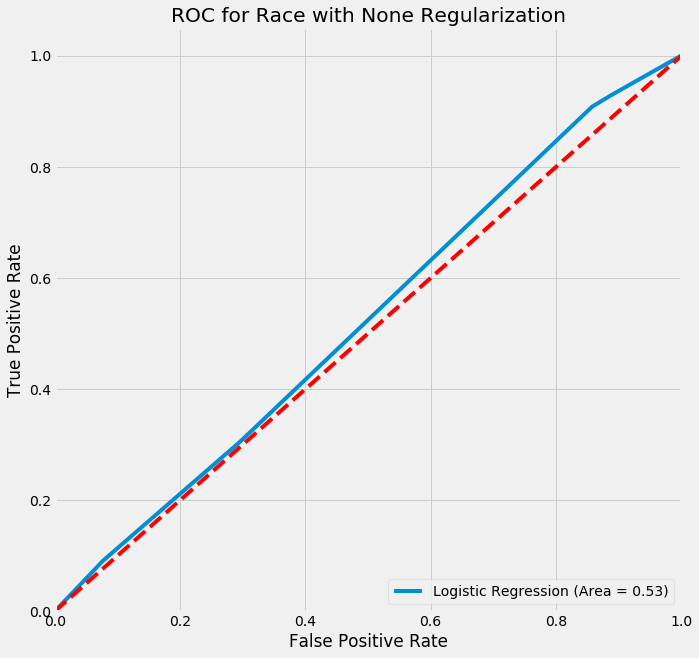

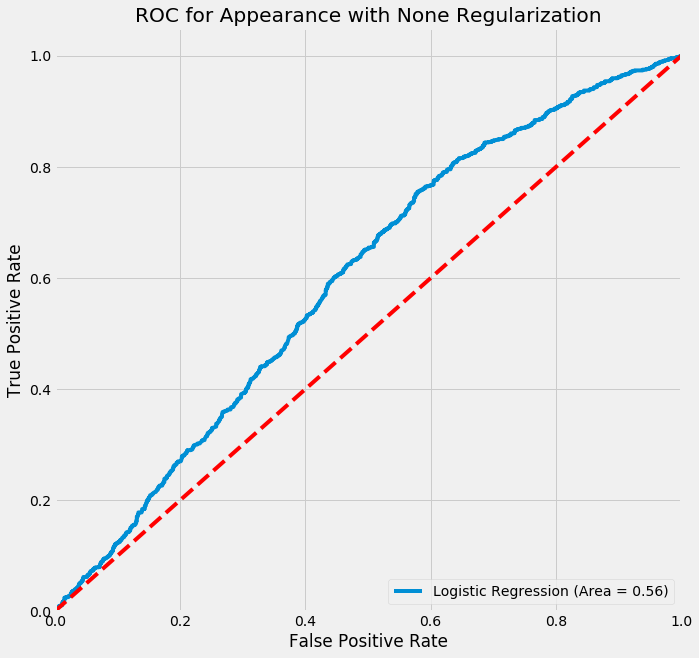

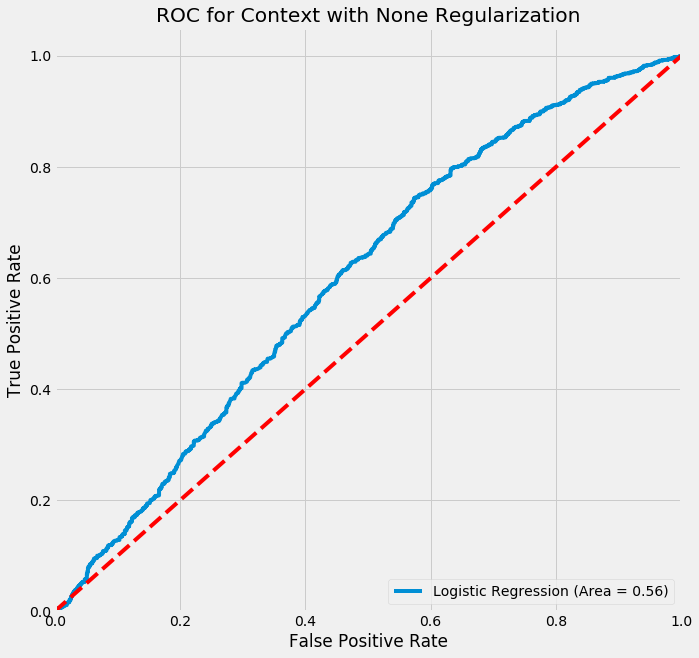

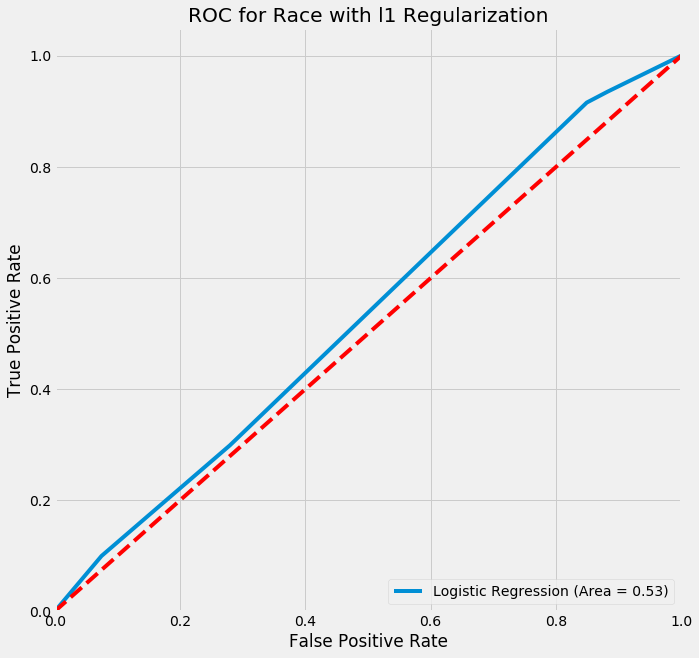

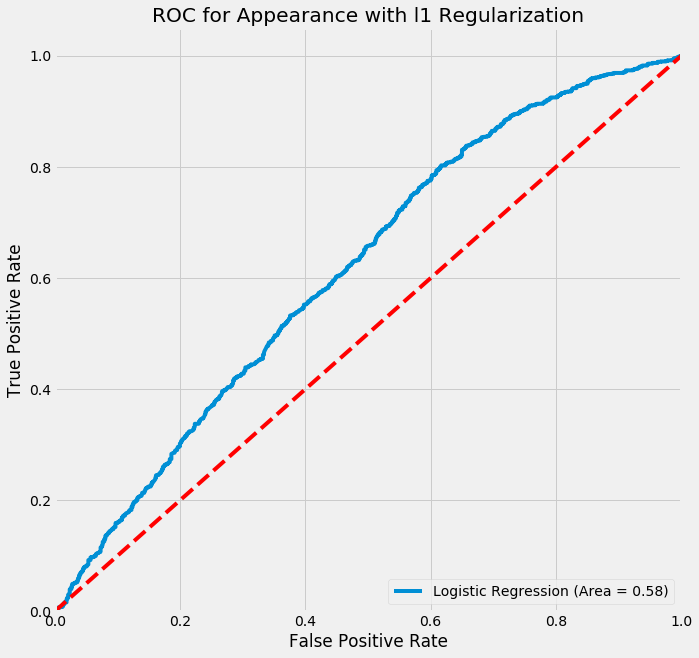

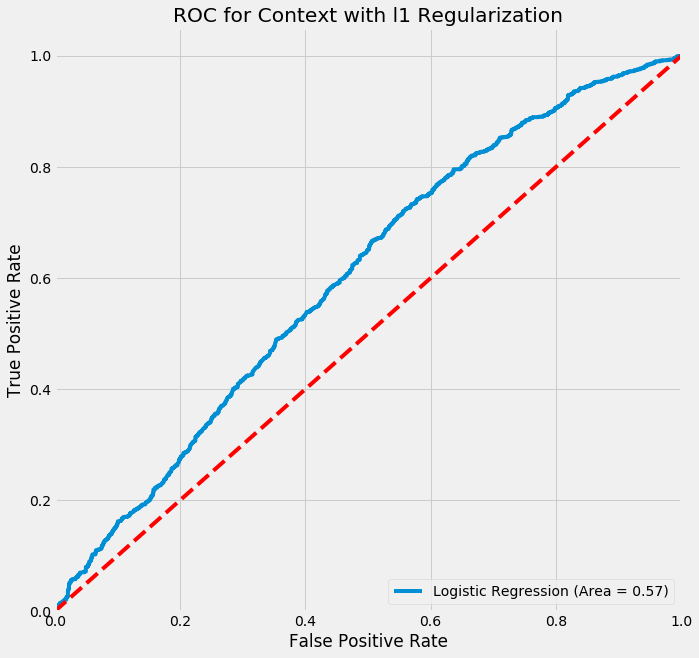

In [6]:
# BLM
np.random.seed(7132013)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

def logistic_reg(df, penalty):
    """
    Create a logistic regression classifier of a dataframe, then visualizes the ROC curve
    
    Input: the feature matrix, which includes the output variable in the first column
    Output: the accuracy, precision, and recall of the matrix

    """

    
    X = df
    y = y_raw
    
    # 80/20 Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
    
    if penalty == 'l1':
        log_reg = LogisticRegression(penalty, solver='liblinear')
        log_reg.fit(X_train, y_train)
        y_pred = log_reg.predict(X_test)
    else:
        log_reg = LogisticRegression()
        log_reg.fit(X_train, y_train)
        y_pred = log_reg.predict(X_test)

    accuracy = log_reg.score(X_test, y_test)
    precision = classification_report(y_test, y_pred, output_dict = True)['weighted avg']['precision']
    recall = classification_report(y_test, y_pred, output_dict = True)['weighted avg']['recall']
    
    log_reg_roc_auc = roc_auc_score(y_test, log_reg.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, log_reg.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label = 'Logistic Regression (Area = %0.2f)' % log_reg_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC for {df.name} with {penalty} Regularization')
    plt.legend(loc="lower right")
    plt.savefig(f'../notebooks/roc_curves/{df.name}{penalty}')
    
    return [accuracy, precision, recall]

race_summary.iloc[0,:] = logistic_reg(race, penalty = None)
appearance_summary.iloc[0,:] = logistic_reg(appearance, penalty = None)
context_summary.iloc[0,:] = logistic_reg(context, penalty = None)

race_summary.iloc[1,:] = logistic_reg(race, penalty = 'l1')
appearance_summary.iloc[1,:] = logistic_reg(appearance, penalty = 'l1')
context_summary.iloc[1,:] = logistic_reg(context, penalty = 'l1')




In [7]:
display(race_summary,appearance_summary, context_summary)

,Accuracy,Precision,Recall
Logistic,0.580247,0.565221,0.580247
Logisitic + Regularization,0.593341,0.584045,0.593341
SVM Linear Kernel,NaN,NaN,NaN
SVM Gaussian Kernel,NaN,NaN,NaN


,Accuracy,Precision,Recall
Logistic,0.594089,0.600498,0.594089
Logisitic + Regularization,0.616162,0.633458,0.616162
SVM Linear Kernel,NaN,NaN,NaN
SVM Gaussian Kernel,NaN,NaN,NaN


,Accuracy,Precision,Recall
Logistic,0.608305,0.61157,0.608305
Logisitic + Regularization,0.610176,0.611179,0.610176
SVM Linear Kernel,NaN,NaN,NaN
SVM Gaussian Kernel,NaN,NaN,NaN


# SVM
In terms of kernel selection, because I am doing a binary classification task with upwards of 50+ features for later models I will use a simple linear kernel and a complex RBF/Gaussian Kernal to observe differences. Further testing needs to be done if my data is possible linearly seperable.

In [8]:
from sklearn.svm import SVC

def svm(df, kernel):
    """
    Create a  classifier of a dataframe
    Input: the feature matrix, which includes the output variable in the first column
    Output: the accuracy, precision, and recall of the matrix

    """

    
    X = df
    y = y_raw
    
    # 80/20 Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
    

    svc = SVC(kernel = kernel)
    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    
    accuracy = svc.score(X_test, y_test)
    precision = classification_report(y_test, y_pred, output_dict = True)['weighted avg']['precision']
    recall = classification_report(y_test, y_pred, output_dict = True)['weighted avg']['recall']
    
  
    return [accuracy, precision, recall]

race_summary.iloc[2,:] =  svm(race, kernel = 'linear')
appearance_summary.iloc[2,:] =  svm(appearance, kernel = 'linear')
context_summary.iloc[2,:] =  svm(context, kernel = 'linear')

race_summary.iloc[3,:] =  svm(race, kernel = 'rbf')
appearance_summary.iloc[3,:] =  svm(appearance, kernel = 'rbf')
context_summary.iloc[3,:] =  svm(context, kernel = 'rbf')

In [9]:
display(race_summary, appearance_summary, context_summary)

,Accuracy,Precision,Recall
Logistic,0.580247,0.565221,0.580247
Logisitic + Regularization,0.593341,0.584045,0.593341
SVM Linear Kernel,0.587729,0.575969,0.587729
SVM Gaussian Kernel,0.57052,0.576572,0.57052


,Accuracy,Precision,Recall
Logistic,0.594089,0.600498,0.594089
Logisitic + Regularization,0.616162,0.633458,0.616162
SVM Linear Kernel,0.621025,0.625309,0.621025
SVM Gaussian Kernel,0.625514,0.636216,0.625514


,Accuracy,Precision,Recall
Logistic,0.608305,0.61157,0.608305
Logisitic + Regularization,0.610176,0.611179,0.610176
SVM Linear Kernel,0.596334,0.626991,0.596334
SVM Gaussian Kernel,0.624392,0.619873,0.624392


#### Observations

What does precision mean in this context? Keep in mind that we are thinking of our machine as a model for an officer in which they are determining if they should frisk a suspect based off their physical appearance. The precision of 0.61 means that of all frisked individuals, our models were able to correctly predict if someone would be frisked based on their race alone, their physical appearance, and overall context about 60% of the time. In terms of real-world behavior, this shows that officers are choosing to frisk on more than looks, race, and context alone. Perhaps they are using their unconscious bias shape the "other 40%" of their decisions. In other words, an unexplained factor may be interactions between race and context

In terms of modeling, using a SVM versus a logistic regression seems to only give us an extra 0.02 points in terms of precision, accuracy, and recall. A Logisitc Regression LASSO seems to be the best model in terms of maximizing our statistics while keeping in mind overfitting.

Overall this leads to a greater discussion about the **fairness of policing**. From a data science and decision theory perspective, we can _consider_ fair policing to mean the following:

* each race is equally likely to be frisked (equal positve rates)
* each race is equally likely to not be frisked (equal error rates)
* each race is equally likely to be frisked on reasonable suspicion, but then no other consequences, say arrest, occurs (equal false positive rates)

Policing is not about being fair across races as much as it is meant to keep peace, enforce the laws, and uphold justice. However, the SQF rhetoric appears to be that having the lowest crime rate is the goal when in reality the negative externality caused by the racial profiling is unacceptable. A further question that could be posed is:

1. If NYPD could achiveve a crime rate that is low but perhaps 1-2% higher than current levels, would we see more policing fairness in terms of race?
2. If not, what are systematic improvements that give minorities a sense of _procedural justice_.
